<a href="https://colab.research.google.com/github/JakubTomaszewski/Traffic-signs-classification/blob/main/TSC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd drive/MyDrive/Colab Notebooks/TSC_ADek

/content/drive/MyDrive/Colab Notebooks/TSC_ADek


In [ ]:
ls data/tsc_dataset/

test/  train/


## Constants

In [ ]:
IMG_WIDTH = 64
IMG_HEIGHT = 64
TRAIN_DATA_PATH = 'data/tsc_dataset/train/'
TEST_DATA_PATH = 'data/tsc_dataset/test/'

## Loading libraries

In [ ]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from tqdm import tqdm
import cv2
import seaborn as sns

from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomContrast, RandomCrop, RandomZoom
from tensorflow.keras import Sequential
import tensorflow as tf

## Loading data

In [ ]:
os.listdir(TRAIN_DATA_PATH)

['30_limit', '50_limit', '70_limit', 'no_entrance', 'other', 'STOP']

In [ ]:
def load_classes(path):
  """Loads all dataset classes into a dict"""
  classes_dict = defaultdict(list)
  for class_dir in os.listdir(path):
    print(f'Loading data from {class_dir}...')
    for file in os.listdir(path+class_dir):
      img = cv2.imread(path+class_dir+'/'+file)
      if img is not None:
        classes_dict[class_dir].append(np.array(img, dtype=np.uint8))
      else:
        print('No image:', path+class_dir+'/'+file)
  return classes_dict

In [ ]:
print('TRAIN')
train_data_dict = load_classes(TRAIN_DATA_PATH)

print('\nTEST')
test_data_dict = load_classes(TEST_DATA_PATH)

TRAIN
Loading data from 30_limit...
Loading data from 50_limit...
Loading data from 70_limit...
Loading data from no_entrance...
Loading data from other...
Loading data from STOP...
No image: data/tsc_dataset/train/STOP/stop_4.jpg

TEST
Loading data from 30_limit...
Loading data from 50_limit...
Loading data from 70_limit...
Loading data from no_entrance...
Loading data from other...
Loading data from STOP...


In [ ]:
print('Train set')
for label, samples in train_data_dict.items():
  print(f'{label}: {len(samples)}')

print('\nTest set')
for label, samples in test_data_dict.items():
  print(f'{label}: {len(samples)}')

Train set
30_limit: 295
50_limit: 223
70_limit: 425
no_entrance: 255
other: 373
STOP: 346

Test set
30_limit: 109
50_limit: 94
70_limit: 225
no_entrance: 82
other: 229
STOP: 71


## Resize images

- ###  Checking the distribution of image sizes

In [ ]:
image_sizes = []

for samples in train_data_dict.values():
  for image in samples:
    image_sizes.append(image.shape)

(array([ 10.,  50., 150., 146., 170., 162., 147., 110., 110.,  91.]),
 array([17. , 25.2, 33.4, 41.6, 49.8, 58. , 66.2, 74.4, 82.6, 90.8, 99. ]),
 <a list of 10 Patch objects>)

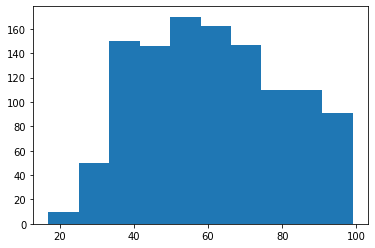

In [ ]:
plt.hist([size[0] for size in image_sizes if size[0] < 100])

- ### Resizing data and create corresponding labels

In [ ]:
def resize_image(img):
  return cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

In [ ]:
resized_train_data = []
resized_test_data = []

for label, samples in train_data_dict.items():
  resized_train_data.append(list(map(resize_image, samples)))

for label, samples in test_data_dict.items():
  resized_test_data.append(list(map(resize_image, samples)))

In [ ]:
train_data = np.concatenate(resized_train_data)
test_data = np.concatenate(resized_test_data)

train_data.shape, test_data.shape

((1917, 64, 64, 3), (810, 64, 64, 3))

## Creating labels

Classes and their labels:

- 30_limit: 0

- 50_limit: 1

- 70_limit: 2

- no_entrance: 3

- STOP: 4

- other: 5


In [ ]:
LABELS_DICT = {
    '30_limit': 0,
    '50_limit': 1,
    '70_limit': 2,
    'no_entrance': 3,
    'STOP': 4,
    'other': 5
}

In [ ]:
NUM_CLASSES = len(LABELS_DICT)
NUM_CLASSES

6

In [ ]:
train_labels = np.concatenate([np.full(len(samples), LABELS_DICT[label], dtype=np.uint8) for label, samples in train_data_dict.items()])
test_labels = np.concatenate([np.full(len(samples), LABELS_DICT[label], dtype=np.uint8) for label, samples in test_data_dict.items()])

train_labels.shape, test_labels.shape

((1917,), (810,))

## EDA

- ### Display some images from each class

In [ ]:
def display_img_byclass(train_data, train_labels):
  fig, ax = plt.subplots(1, len(np.unique(train_labels)), figsize=(12,7))

  for i, class_name in enumerate(np.unique(train_labels)):
    for img, label in zip(train_data, train_labels):
      if label == class_name:
        ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='gray')
        break

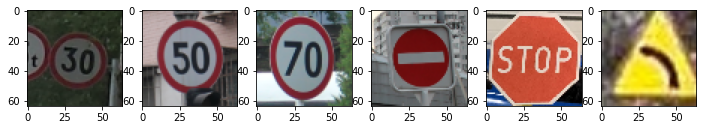

In [ ]:
display_img_byclass(train_data, train_labels)

## Concatenate data

In [ ]:
train_data.shape, train_labels.shape

((1917, 64, 64, 3), (1917,))

In [ ]:
test_data.shape, test_labels.shape

((810, 64, 64, 3), (810,))

In [ ]:
train_data_full =  np.concatenate([train_data, test_data])
train_labels_full =  np.concatenate([train_labels, test_labels])

In [ ]:
train_data_full.shape, train_labels_full.shape

((2727, 64, 64, 3), (2727,))

## Data augmentation

- ### Defining data augmentation object

In [ ]:
class DataAugmentor:
  def __init__(self, image_width, image_height):
    self._image_width = image_width
    self._image_height = image_height
    self._augmentor_pipeline = Sequential()

  def reset_augmentor():
    self._augmentor_pipeline = Sequential()

  def add_rotate(self, max_angle_percentage=0.075):
    self._augmentor_pipeline.add(RandomRotation(max_angle_percentage))

  def add_contrast(self, max_contrast_percentage=0.4):
    self._augmentor_pipeline.add(RandomContrast(max_contrast_percentage))

  def add_zoom(self, max_zoom_percentage=0.2):
    self._augmentor_pipeline.add(RandomZoom(max_zoom_percentage))

  def translate_image(self, image, max_translate_percentage=0.12):
    return tf.keras.preprocessing.image.random_shift(image, max_translate_percentage, max_translate_percentage)

  def transform_image(self, image):
    translated_img = self.translate_image(image)

    if self._augmentor_pipeline is not None:
      expanded_img = np.array(tf.expand_dims(translated_img, 0))
      augmented_img = (self._augmentor_pipeline(expanded_img)).numpy()
      translated_img = augmented_img.reshape((self._image_width, self._image_height, 3))
    return translated_img

  def transform_dataset(self, data):
    length = len(data)
    translated_data = np.array(list(map(self.translate_image, data)))

    if self._augmentor_pipeline is not None:
      expanded_data = np.array([tf.expand_dims(img, 0) for img in translated_data])
      augmented_data = np.array([(self._augmentor_pipeline(img)).numpy() for img in expanded_data])
      translated_data = augmented_data.reshape((length, self._image_width, self._image_height, 3))
    return translated_data

  def get_info(self):
    if self._augmentor_pipeline is not None:
      print(self._augmentor_pipeline)

In [ ]:
augmentor = DataAugmentor(IMG_WIDTH, IMG_HEIGHT)
augmentor.add_rotate()
augmentor.add_contrast()
augmentor.add_zoom()

In [ ]:
x = augmentor.transform_image(train_data_full[1000])

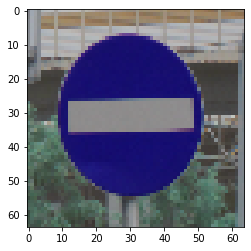

In [ ]:
plt.imshow(train_data_full[1000], cmap='gray')

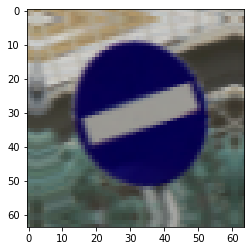

In [ ]:
plt.imshow(x, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


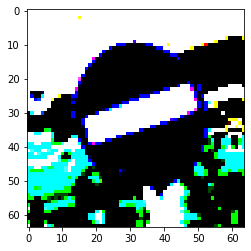

In [ ]:
plt.imshow(x - np.mean(x), cmap='gray')

- ### How many samples to create for each class

Current number of images per class

- Train

In [ ]:
train_samples_class = Counter(train_labels_full)
train_samples_class

Counter({0: 404, 1: 317, 2: 650, 3: 337, 4: 417, 5: 602})

In [ ]:
TRAIN_IMAGES_PER_CLASS = 2000

Creating dict containing number of samples to create for each class

- Train

In [ ]:
train_samples_to_create = dict()

for c, num_samples in train_samples_class.items():
  print(f'Creating {TRAIN_IMAGES_PER_CLASS - num_samples} for class {c}')
  train_samples_to_create[c] = max(TRAIN_IMAGES_PER_CLASS - num_samples, 0)

train_samples_to_create

Creating 1596 for class 0
Creating 1683 for class 1
Creating 1350 for class 2
Creating 1663 for class 3
Creating 1398 for class 5
Creating 1583 for class 4


{0: 1596, 1: 1683, 2: 1350, 3: 1663, 4: 1583, 5: 1398}

### Creating data

In [ ]:
def augment_data(data, labels, num_samples_dict):
  """Applies data_augment function to the dataset, creates new samples"""

  new_data_array = []
  new_labels_array = []

  for c, num_samples in num_samples_dict.items():
    print(f'\nGenerating samples for class {c}')
    # Setting only data with current labels
    current_class_images = data[labels == c]
    while num_samples > 0:
      if num_samples % 100 == 0:
        print(c, num_samples)
      # Choosing a random image with a specific class
      random_image = current_class_images[np.random.randint(0, len(current_class_images - 1))]

      aug_image = augmentor.transform_image(random_image)
      
      new_data_array.append(aug_image)
      new_labels_array.append(c)
      num_samples -= 1
    
  np_new_data_array = np.array(new_data_array)
  np_new_labels_array = np.array(new_labels_array)
  
  print(f'\nCreated {np_new_data_array.shape[0]} training samples with {np_new_labels_array.shape[0]} labels')

  data_aug = np.concatenate((data, np_new_data_array))
  labels_aug = np.concatenate((labels, np_new_labels_array))

  print(f'After concatenation with the original dataset: {data_aug.shape[0]} training samples with {labels_aug.shape[0]} labels')
 
  return data_aug, labels_aug

- Train

In [ ]:
train_data_aug, train_labels_aug = augment_data(train_data_full, train_labels_full, train_samples_to_create)


Generating samples for class 0
0 1500
0 1400
0 1300
0 1200
0 1100
0 1000
0 900
0 800
0 700
0 600
0 500
0 400
0 300
0 200
0 100

Generating samples for class 1
1 1600
1 1500
1 1400
1 1300
1 1200
1 1100
1 1000
1 900
1 800
1 700
1 600
1 500
1 400
1 300
1 200
1 100

Generating samples for class 2
2 1300
2 1200
2 1100
2 1000
2 900
2 800
2 700
2 600
2 500
2 400
2 300
2 200
2 100

Generating samples for class 3
3 1600
3 1500
3 1400
3 1300
3 1200
3 1100
3 1000
3 900
3 800
3 700
3 600
3 500
3 400
3 300
3 200
3 100

Generating samples for class 5
5 1300
5 1200
5 1100
5 1000
5 900
5 800
5 700
5 600
5 500
5 400
5 300
5 200
5 100

Generating samples for class 4
4 1500
4 1400
4 1300
4 1200
4 1100
4 1000
4 900
4 800
4 700
4 600
4 500
4 400
4 300
4 200
4 100

Created 9273 training samples with 9273 labels
After concatenation with the original dataset: 12000 training samples with 12000 labels


In [ ]:
train_data_aug.shape, train_labels_aug.shape

((12000, 64, 64, 3), (12000,))

- ### Saving generated datasets

In [ ]:
np.save('data/train_data_aug_full.npy', train_data_aug)
np.save('data/train_labels_aug_full.npy', train_labels_aug)

- ### Loading augmented datasets (if not loaded yet)

In [ ]:
train_data_aug = np.load('data/train_data_aug_full.npy')
train_labels_aug = np.load('data/train_labels_aug_full.npy')

## Preprocessing

In [ ]:
class ImgPreprocessor:
  def __init__(self):
    pass

  def resize_image(self, image, width, height):
    """Resizes an image to a given shape

    Parameters
    ----------
    image -- image to be resized

    width -- new image width

    height -- new image height

    Returns
    -------
    resized image
    """
    
    return cv2.resize(image, (width, height))

  def convert_to_grayscale(self, image):
    """Converts an image to grayscale
    
    Parameters
    ----------
    image -- a numpy array represeting an image wth 3 color channels

    Returns
    -------
    image in grayscale without a color channel;
    """
    
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


  def normalize_image(self, image):
    """Normalizes an image by substracting the mean from each channel
    
    Parameters
    ----------
    image -- a numpy array representing an image

    Returns
    -------
    Normalized image  
    """
    
    return image - int(np.mean(image))


  def histogram_equalization(self, image):
    """
    Parameters
    ----------
    image -- a numpy array representing an image in grayscale (without a color channel)

    Returns
    -------
    image of equalized grayscale
    """
    
    return cv2.equalizeHist(image)


  def preprocess_image(self, image, width, height):
    """Applies grayscale transformation, equalization and normalization to an image

    Parameters
    ----------
    image -- a numpy array representing an image

    Returns
    -------
    preprocessed image
    """

    resized = self.resize_image(image, width, height)
    gray = self.convert_to_grayscale(resized)
    # equalized = histogram_equalization(gray)
    normalized = self.normalize_image(gray)
    
    return normalized

  def transform_data(self, data, width, height):
    """Applies preprocess_image to the whole dataset"""
    return np.array([self.preprocess_image(img, width, height) for img in data])

In [ ]:
img_preprocessor = ImgPreprocessor()

- ### Train

In [ ]:
preprocessed_train = img_preprocessor.transform_data(train_data_aug, IMG_WIDTH, IMG_HEIGHT)
preprocessed_train.shape, train_labels_aug.shape

((12000, 64, 64), (12000,))

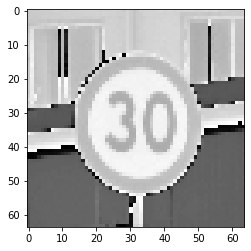

In [ ]:
plt.imshow(preprocessed_train[10], cmap='gray')

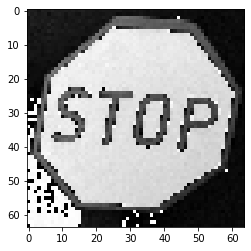

In [ ]:
plt.imshow(preprocessed_train[1600], cmap='gray')

## Importing libraries for training

In [ ]:
from datetime import datetime

import keras
from keras import Model
from keras.regularizers import l1, l2, l1_l2
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Dropout, BatchNormalization, Activation, GlobalMaxPooling2D, Dense
from keras.optimizers import Adam, Adamax, SGD, RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
%load_ext tensorboard

## Preparing data for training

- ### Shuffle the data

In [ ]:
def shuffle_both_arrays(arr_one, arr_two):
  assert len(arr_one) == len(arr_two)
  p = np.random.permutation(len(arr_one))
  return arr_one[p], arr_two[p]

In [ ]:
preprocessed_train, train_labels_aug = shuffle_both_arrays(preprocessed_train, train_labels_aug)

- ### Add 1 dimension to the data

In [ ]:
preprocessed_train.shape

(12000, 64, 64)

In [ ]:
X_train_reshaped = preprocessed_train.reshape((*preprocessed_train.shape, 1))

X_train_reshaped.shape

(12000, 64, 64, 1)

- ### Split test set to test and validation sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train_reshaped, train_labels_aug, test_size=0.2, random_state=42, stratify=train_labels_aug)

In [ ]:
print(f'Train set: {X_train.shape} {y_train.shape}')
print(f'Test set: {X_test.shape} {y_test.shape}')

Train set: (9600, 64, 64, 1) (9600,)
Test set: (2400, 64, 64, 1) (2400,)


- ### OneHotEncoding features

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train.shape, y_test.shape

((9600, 6), (2400, 6))

## Training

- ### Defining models

In [ ]:
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 1)

In [ ]:
# def create_model(optimizer=Adamax(), lr=0.01, activation='elu'):
#   optimizer.learning_rate = lr

#   input_tensor = Input(INPUT_SHAPE)
#   X = Conv2D(32, (3, 3), padding='same', activation=activation)(input_tensor)
#   X = BatchNormalization(axis=-1)(X)
#   X = MaxPooling2D((2, 2))(X)

#   X = Conv2D(64, (3, 3), padding='same', activation=activation)(X)
#   X = BatchNormalization(axis=-1)(X)
#   X = Conv2D(64, (3, 3), padding='same', activation=activation)(X)
#   X = BatchNormalization(axis=-1)(X)
#   X = MaxPooling2D((2, 2))(X)

#   X = GlobalMaxPooling2D()(X)

#   X = Dense(64, activation=activation, kernel_regularizer=l2(0.01))(X)
#   X = Dropout(0.35)(X)

#   X = Dense(32, activation=activation, kernel_regularizer=l2(0.01))(X)
#   X = Dropout(0.35)(X)

#   output = Dense(NUM_CLASSES, activation='softmax')(X)

#   model = Model(inputs=input_tensor, outputs=output)
#   model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics='accuracy')
#   # print(model.summary())
#   return model


def create_model_flat(optimizer=Adamax(), lr=0.01, activation='relu'):
  optimizer.learning_rate = lr

  input_tensor = Input(INPUT_SHAPE)
  X = Conv2D(32, (3, 3), padding='same', activation=activation)(input_tensor)
  X = BatchNormalization(axis=-1)(X)
  X = MaxPooling2D((2, 2))(X)

  X = Conv2D(64, (3, 3), padding='same', activation=activation)(X)
  X = BatchNormalization(axis=-1)(X)
  X = Conv2D(64, (3, 3), padding='same', activation=activation)(X)
  X = BatchNormalization(axis=-1)(X)
  X = MaxPooling2D((2, 2))(X)

  X = Flatten()(X)

  X = Dense(64, activation=activation, kernel_regularizer=l2(0.001))(X)
  X = Dropout(0.5)(X)

  X = Dense(32, activation=activation, kernel_regularizer=l2(0.001))(X)
  X = Dropout(0.35)(X)

  output = Dense(NUM_CLASSES, activation='softmax')(X)

  model = Model(inputs=input_tensor, outputs=output)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics='accuracy')
  # print(model.summary())
  return model


def simple_model_build(activation='relu'):
  inputs = Input(INPUT_SHAPE)
  x = BatchNormalization()(inputs)

  x = Conv2D(16, 3, activation=activation)(x)
  x = MaxPooling2D(2)(x)
  x = BatchNormalization()(x)

  x = Conv2D(32, 3, activation=activation)(x)
  x = MaxPooling2D(2)(x)
  x = BatchNormalization()(x)

  x = Conv2D(64, 3, activation=activation)(x)
  x = MaxPooling2D(2)(x)
  x = BatchNormalization()(x)

  x = GlobalMaxPooling2D()(x)
  # x = Dense(32, activation='relu')(x)
  # x = Dropout(.4)(x)
  x = Dense(64, activation=activation, kernel_regularizer=l2(0.001))(x)
  x = Dropout(.5)(x)
  x = Dense(32, activation=activation, kernel_regularizer=l2(0.001))(x)  # , kernel_regularizer=l2(0.01)
  x = Dropout(.35)(x)
  x = Dense(NUM_CLASSES, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=x)
  model.compile(Adamax(learning_rate=0.01), loss='categorical_crossentropy', metrics='accuracy')
  # print(model.summary())

  return model

- ### Training

In [ ]:
models = [
          KerasClassifier(create_model_flat, epochs=15, batch_size=32),
          KerasClassifier(simple_model_build, epochs=15, batch_size=32)
          ]

- ### Choosing the best model using cross validation

In [ ]:
results = []

for model in models:
  result = cross_val_score(model, X_train, y_train, cv=4)
  results.append(result)

Epoch 1/10
225/225 [==============================] - 6s 24ms/step - loss: 3.3376 - accuracy: 0.4022
Epoch 2/10
225/225 [==============================] - 5s 23ms/step - loss: 1.4930 - accuracy: 0.5838
Epoch 3/10
225/225 [==============================] - 5s 23ms/step - loss: 1.2426 - accuracy: 0.6660
Epoch 4/10
225/225 [==============================] - 5s 23ms/step - loss: 1.0425 - accuracy: 0.7265
Epoch 5/10
225/225 [==============================] - 5s 23ms/step - loss: 0.9110 - accuracy: 0.7690
Epoch 6/10
225/225 [==============================] - 5s 23ms/step - loss: 0.8356 - accuracy: 0.8062
Epoch 7/10
225/225 [==============================] - 5s 23ms/step - loss: 0.7412 - accuracy: 0.8357
Epoch 8/10
225/225 [==============================] - 5s 23ms/step - loss: 0.6321 - accuracy: 0.8688
Epoch 9/10
225/225 [==============================] - 5s 23ms/step - loss: 0.5715 - accuracy: 0.8883
Epoch 10/10
75/75 [==============================] - 1s 8ms/step - loss: 0.4741 - accuracy:

In [ ]:
for result in results:
  print(result)

[0.92666668 0.92958331 0.92208332 0.94375002]
[0.84041667 0.84583336 0.83625001 0.83999997]


In [ ]:
for result in results:
  print(result.mean())

0.9305208325386047
0.8406250029802322


- ### Final training

In [ ]:
model = simple_model_build()

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=32)  #, validation_data=(X_val, y_val)

Epoch 1/10
270/270 [==============================] - 6s 17ms/step - loss: 1.9003 - accuracy: 0.3408 - val_loss: 1.0546 - val_accuracy: 0.6333
Epoch 2/10
270/270 [==============================] - 4s 16ms/step - loss: 1.0650 - accuracy: 0.6106 - val_loss: 0.6923 - val_accuracy: 0.7823
Epoch 3/10
270/270 [==============================] - 4s 16ms/step - loss: 0.7861 - accuracy: 0.7461 - val_loss: 0.5180 - val_accuracy: 0.8406
Epoch 4/10
270/270 [==============================] - 4s 16ms/step - loss: 0.5677 - accuracy: 0.8348 - val_loss: 0.4636 - val_accuracy: 0.8594
Epoch 5/10
270/270 [==============================] - 4s 16ms/step - loss: 0.4543 - accuracy: 0.8808 - val_loss: 0.3451 - val_accuracy: 0.8948
Epoch 6/10
270/270 [==============================] - 4s 16ms/step - loss: 0.3979 - accuracy: 0.8964 - val_loss: 0.3576 - val_accuracy: 0.8979
Epoch 7/10
270/270 [==============================] - 4s 16ms/step - loss: 0.3185 - accuracy: 0.9200 - val_loss: 0.2822 - val_accuracy: 0.9135

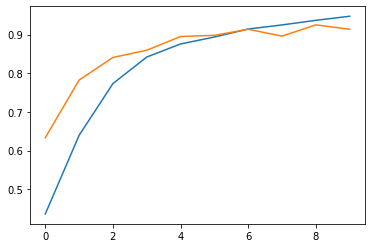

In [ ]:
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')

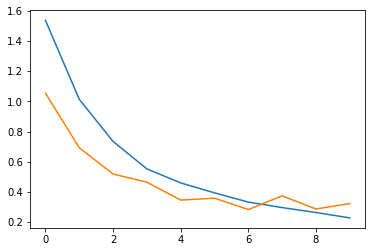

In [ ]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')

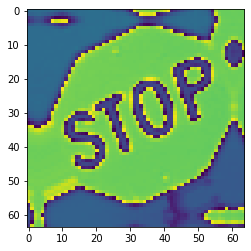

In [ ]:
plt.imshow(X_test[1400].reshape(64, 64))

In [ ]:
np.argmax(model.predict(X_test[1400].reshape(1, 64, 64, 1)))

4

In [ ]:
model.evaluate(X_test, y_test)

75/75 [==============================] - 0s 5ms/step - loss: 0.3246 - accuracy: 0.9183


[0.324623167514801, 0.9183333516120911]

In [ ]:
model.evaluate(X_train, y_train)

300/300 [==============================] - 1s 5ms/step - loss: 0.2004 - accuracy: 0.9541


[0.20036980509757996, 0.9540625214576721]

In [ ]:
model.save('best_model_92.h5')

In [ ]:
# model = keras.models.load_model('best_model.h5')

In [ ]:
LABELS_DICT

{'30_limit': 0,
 '50_limit': 1,
 '70_limit': 2,
 'STOP': 4,
 'no_entrance': 3,
 'other': 5}

In [ ]:
test_images_path = 'test_images/'

for image in os.listdir(test_images_path):
  img = cv2.imread(test_images_path + image)
  preprocessed = img_preprocessor.preprocess_image(img, IMG_WIDTH, IMG_HEIGHT)
  ready_img = preprocessed.reshape(1, 64, 64, 1)
  # plt.imshow(preprocessed)
  prediction = np.argmax(model.predict(ready_img))
  print('real image:', image)
  print('predicted:', prediction)
  print('\n')

real image: stop.jpg
predicted: 4


real image: no_entry.jpg
predicted: 3


real image: other.jpg
predicted: 3


real image: 70.jpg
predicted: 2


real image: 50.jpg
predicted: 1


real image: 30.jpg
predicted: 0




In [ ]:
y_pred = model.predict(X_test)

In [ ]:
cm = confusion_matrix([np.argmax(pred) for pred in y_test], [np.argmax(pred) for pred in y_pred])
cm

array([[347,  33,   0,   6,   6,   8],
       [  2, 376,  14,   3,   1,   4],
       [  5,  28, 352,   2,   1,  12],
       [  0,   0,   0, 386,   2,  12],
       [  1,   0,   0,   9, 388,   2],
       [  1,   4,   0,  32,   8, 355]])

In [ ]:
confusion_matrix([np.argmax(pred) for pred in y_test], [np.argmax(pred) for pred in y_pred])

array([[273,   9,  12,   2,   0,   4],
       [  2, 287,   7,   1,   0,   3],
       [  1,   3, 290,   0,   0,   6],
       [  0,   0,   0, 292,   0,   8],
       [  0,   0,   0,   3, 292,   5],
       [  0,   2,   3,  11,   0, 284]])

In [ ]:
import seaborn as sns

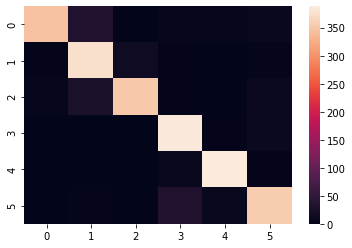

In [ ]:
sns.heatmap(cm)